# Ejercicio1: Prediccion de Riesgo de Diabetes
Utiliza un dataset que incluye datos sobre registros médicos de pacientes femeninas para determinar si un paciente tiene diabetes o no.

## 1.Carga y exploracion general de datos

En este apartado vamos a poder observar una primera exploracion de los datos y como estan conformados

### Librerias

Primero importamos todas las librerias que vamos a utilizar en todo el ejercicio

In [1]:
import polars as pl
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

### Cargar el dataset

En este paso se carga el dataset de diabetes usando la librería Polars 

In [2]:
df = pl.read_csv("diabetes.csv")

### Filas y columnas

Conocemos el numero de filas y columnas del dataframe

In [3]:
print("Numero de filas:", df.height)
print("Numero de columnas:", df.width)

Numero de filas: 768
Numero de columnas: 9


### Estructura del dataframe

Para comenzar con el análisis, se pudo observar la estructura interna del DataFrame. Esto nos permite conocer las columnas que lo conforman, así como el tipo de dato de cada una. Esta información es esencial para garantizar que los datos tengan el formato adecuado antes de aplicar técnicas de análisis o modelado.
Se obtuvo:
- Pregnancies: Número de embarazos que ha tenido la paciente.
- Glucose: Nivel de glucosa en sangre 
- BloodPressure: Presión arterial diastólica 
- SkinThickness: Espesor del pliegue cutáneo del tríceps 
- Insulin: Nivel de insulina en sangre
- BMI: Indice de masa corporal 
- DiabetesPedigreeFunction: Estimación de la predisposición genética a desarrollar diabetes
- Age: Edad de la paciente 
- Outcome: Variable objetivo: 0 indica no diabetes, 1 indica diagnóstico positivo

In [4]:
df.schema

Schema([('Pregnancies', Int64),
        ('Glucose', Int64),
        ('BloodPressure', Int64),
        ('SkinThickness', Int64),
        ('Insulin', Int64),
        ('BMI', Float64),
        ('DiabetesPedigreeFunction', Float64),
        ('Age', Int64),
        ('Outcome', Int64)])

### Primera visualizacion

Haremos una primera visualizacion de las primeras filas el dataframe para poder ver como se encuentran organizados los datos.Esta visualización preliminar permite observar los valores que contiene cada columna, identificar posibles anomalías, ceros o patrones en los datos.
Se observa que algunas columnas presentan valores igual a 0 en registros donde no serían clínicamente válidos (por ejemplo, Insulin, SkinThickness o BloodPressure), lo cual será tratado posteriormente en la etapa de limpieza de datos.

In [5]:
df.head()

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
i64,i64,i64,i64,i64,f64,f64,i64,i64
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


### Resumen Estadistico

Para poder ver el dataframe de manera mas general generamos unas estadisticas descriptivas de cada variable incluyendo la media, desviación estándar, valores mínimos, máximos, cuartiles y conteo de nulos.
Estas estadísticas permiten detectar posibles valores atípicos o inconsistencias que deben considerarse durante el proceso de limpieza y análisis.
Podemos observar que:
- No hay valores nulos explícitos, pero algunas columnas como Insulin, SkinThickness o BloodPressure tienen valores mínimos bajos 
- El promedio de glucosa es de 121.69, pero hay valores desde 44 hasta 199, lo cual puede indicar pacientes con hipoglucemia y otros con hiperglucemia.
- La variable Outcome es binaria, con media de 0.349, lo que sugiere que aproximadamente el 35% de los casos fueron diagnosticados con diabetes.
- Las columnas presentan diferentes escalas (por ejemplo, Age y Glucose tienen magnitudes diferentes a BMI o PedigreeFunction), lo cual se debe considerar en la etapa de escalado de variables.

In [6]:
df.describe()

statistic,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
"""std""",3.369578,31.972618,19.355807,15.952218,115.244002,7.88416,0.331329,11.760232,0.476951
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.078,21.0,0.0
"""25%""",1.0,99.0,62.0,0.0,0.0,27.3,0.244,24.0,0.0
"""50%""",3.0,117.0,72.0,23.0,32.0,32.0,0.374,29.0,0.0
"""75%""",6.0,140.0,80.0,32.0,127.0,36.6,0.626,41.0,1.0
"""max""",17.0,199.0,122.0,99.0,846.0,67.1,2.42,81.0,1.0


### Tipos de datos

Verificaremos los tipos de datos de cada columna del dataframe y nos aseguraremos que cada variable tenga un tipo de dato adecuado para su analisis

In [7]:
df.dtypes

[Int64, Int64, Int64, Int64, Int64, Float64, Float64, Int64, Int64]

### Valores Nulos

Haremos un primer conteo para ver si hay valores nulos y saber como empezar a manejar el dateframe, en este primer conteo se puede observar que no se cuenta que ningun valor nulo en ninguna columna. 
Sin embargo, es importante mencionar que en algunos datasets médicos (como este), los valores cero pueden representar datos faltantes implícitos, especialmente en variables como: Glucose, BloodPressure, SkinThickness, Insulin, BMI
Por ejemplo, una presión arterial de 0  o un nivel de insulina de 0 no son clínicamente viables, y probablemente indican valores no registrados en su momento.

In [8]:
df.null_count()

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


## 2.Limpieza Basica

En esta etapa se realizaron procesos de depuración para asegurar que los datos estén en condiciones óptimas antes de aplicar análisis estadísticos y modelos de ML

### Eliminar duplicados

Se aplico la eliminacion de filas duplicadas para evitar sobreajuste ocasiado por informacion repetida, mejora la calidad del dataset al evitar redundancias y asi reducir su tamaño para hacer mas eficiente el precesamiento

In [9]:
df = df.unique()

### Valores unicos 

En esta parte nos permite detectar variables categoricas, continuas o con poco variacion: 
- DiabetesPedigreeFunction, BMI y Glucose muestran una alta cantidad de valores únicos, lo que confirma que son variables continuas.
- Outcome tiene solo 2 valores únicos (0 y 1), por lo que es claramente binaria y será utilizada como variable objetivo para la clasificación.
- Pregnancies tiene 17 valores únicos, lo que indica una variable discreta con buena variabilidad.

In [10]:
print("Valores únicos por columna:")
for col in df.columns:
    print(f"{col}: {df.select(pl.col(col)).unique().height}")

Valores únicos por columna:
Pregnancies: 17
Glucose: 136
BloodPressure: 47
SkinThickness: 51
Insulin: 186
BMI: 248
DiabetesPedigreeFunction: 517
Age: 52
Outcome: 2


### Columnas con 0

Haremos un conteo de 0 por cada variable para identificar y limpiar estos datos.
Por ejemplo podemos observar que en Glucose hay 5 registros con valor 0 los cual es improbable para niveles reales de glucosa. Sabiendo esto podemos saber como continuar con nuesta limpieza

In [11]:
cols_invalidas = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

print("\nConteo de ceros por columna:")
for col in cols_invalidas:
    num_ceros = df.filter(pl.col(col) == 0).height
    print(f"{col}: {num_ceros} ceros")


Conteo de ceros por columna:
Glucose: 5 ceros
BloodPressure: 35 ceros
SkinThickness: 227 ceros
Insulin: 374 ceros
BMI: 11 ceros


### Ceros invalidos por nulos

Reemplazamos los valores cero en ciertas columnas específicas como lo son Glucose, BloodPressure, SkinThickness, Insulin y BMI por valores nulos, para indicar que esos datos son faltantes o inválidos.
Ya que nn las variables seleccionadas, un valor de cero no tiene sentido fisiológico, por lo que probablemente representa datos faltantes o errores de registro.
Reemplazar los ceros por nulos es fundamental para luego poder aplicar técnicas de imputación

In [12]:
for col in cols_invalidas:
    df = df.with_columns([
        pl.when(pl.col(col) == 0).then(None).otherwise(pl.col(col)).alias(col)
    ])

### Valores extremos

Este análisis ayuda a detectar valores extremos o potenciales outliers que podrían afectar el modelo. Permite entender la escala de las variables y decidir si es necesario aplicar técnicas de normalización o escalado asi mismo facilita la identificación de valores atípicos que podrían ser errores o casos relevantes.

Por ejemplo, la variable Pregnancies (embarazos) va de 0 a 17, indicando que algunas pacientes han tenido hasta 17 embarazos. Los valores mínimos y máximos para variables como Glucose o BloodPressure están dentro de rangos fisiológicamente posibles, lo que confirma que los datos están en una escala razonable. Valores máximos altos en variables como Insulin o BMI indican que hay pacientes con niveles muy elevados o fuera del rango típico, lo cual puede ser relevante para el análisis.



In [13]:
print("\nValores extremos (min, max):")
for col in df.columns[:-1]:  
    min_val = df.select(pl.col(col).min()).item()
    max_val = df.select(pl.col(col).max()).item()
    print(f"{col}: min = {min_val}, max = {max_val}")


Valores extremos (min, max):
Pregnancies: min = 0, max = 17
Glucose: min = 44, max = 199
BloodPressure: min = 24, max = 122
SkinThickness: min = 7, max = 99
Insulin: min = 14, max = 846
BMI: min = 18.2, max = 67.1
DiabetesPedigreeFunction: min = 0.078, max = 2.42
Age: min = 21, max = 81


### Conteo de nulos

Hacemos un conteo nulos por cada variable antes de imputar para tener un control

In [14]:
print("\nValores nulos antes de imputar:")
df.null_count()


Valores nulos antes de imputar:


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,5,35,227,374,11,0,0,0


### Imputacion con la media

Aplicamos imputacion, calculamos la media de la columna y luego sustituimos todos los valores nulos en esa columna con la media calculada. Asi evitamos eliminar filas completas y conservar la mayor contidad de datos para el analisis

In [15]:
for col in cols_invalidas:
    media = df.select(pl.col(col)).mean().item()
    df = df.with_columns(pl.col(col).fill_null(media))

### Verificacion final 

Verificamos que no quede ningun valor nulo despues de aplicar la imputacion

In [16]:
print("\nValores nulos después de imputar:")
df.null_count()


Valores nulos después de imputar:


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


### Resumen estadistico

Veremos un resumen estadistico despues de la limpieza y podemos observar que la imputacion fue efectiva que ya hay 0 valores nulos, y vemos que siguen habiendo 768 filas, es decir no perdimos datos en el proceso

In [17]:
print("\nResumen estadístico después de la limpieza:")
df.describe()


Resumen estadístico después de la limpieza:


statistic,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.845052,121.686763,72.405184,29.15342,155.548223,32.457464,0.471876,33.240885,0.348958
"""std""",3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
"""min""",0.0,44.0,24.0,7.0,14.0,18.2,0.078,21.0,0.0
"""25%""",1.0,100.0,64.0,25.0,122.0,27.5,0.244,24.0,0.0
"""50%""",3.0,117.0,72.405184,29.15342,155.548223,32.4,0.374,29.0,0.0
"""75%""",6.0,140.0,80.0,32.0,155.548223,36.6,0.626,41.0,1.0
"""max""",17.0,199.0,122.0,99.0,846.0,67.1,2.42,81.0,1.0


## 3.Analisis exploratorio + visualizacion inicial

En esta sección se analizan gráficamente las características del conjunto de datos para identificar patrones, distribuciones o relaciones importantes entre variables.

### Convertimos a pandas

In [18]:
df_pd = df.to_pandas()

### Histograma

Generamos histogramas de las variables para ver la distribucion de los valores. Por ejemplo la variable Pregnancies se muestra con una distribucion sesgada a la derecha es decir mas embarazos pocos frecuentes

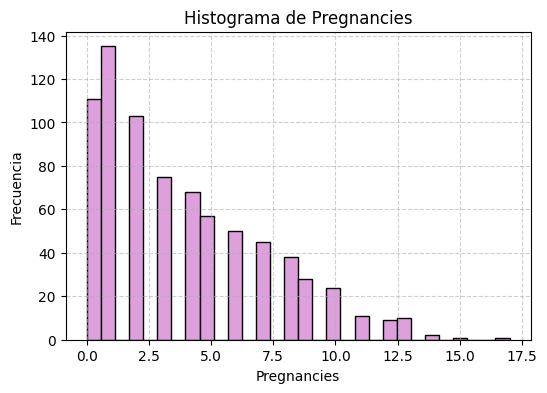

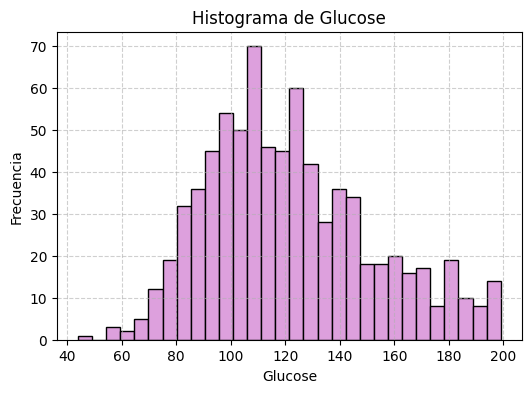

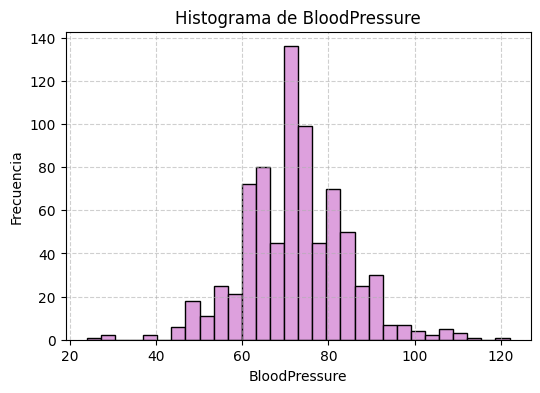

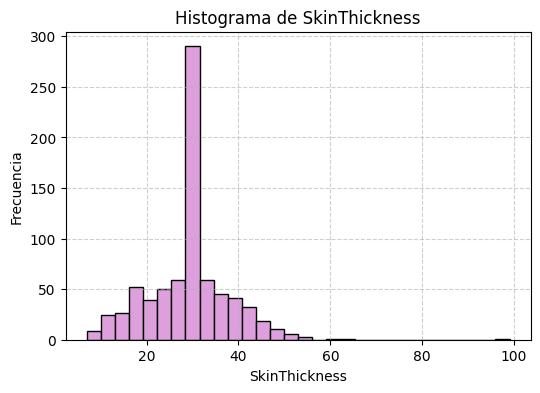

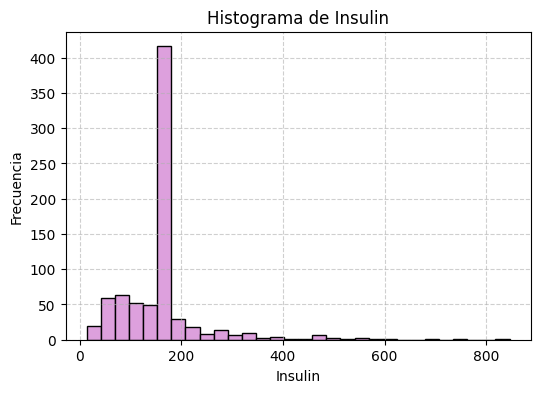

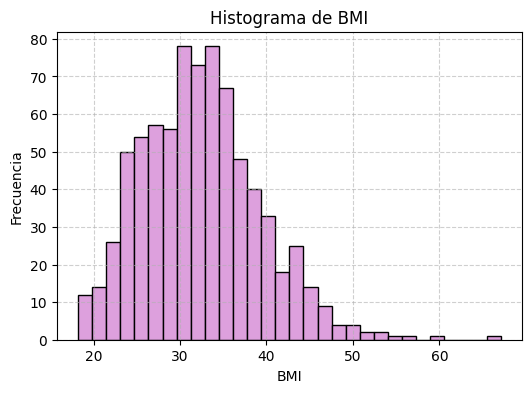

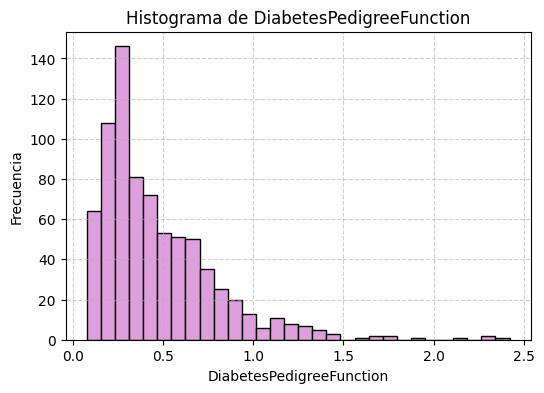

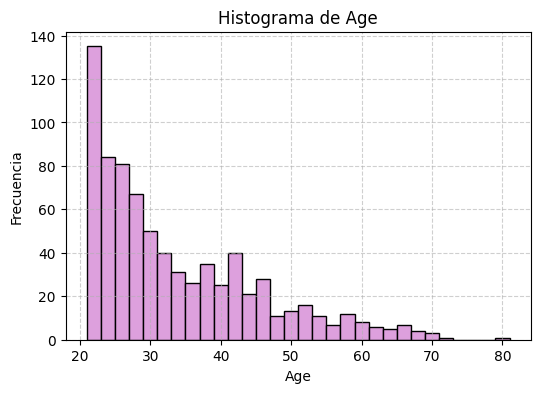

In [19]:
numerical_cols = df_pd.select_dtypes(include=['number']).columns.tolist()
if 'Outcome' in numerical_cols:
    numerical_cols.remove('Outcome')

# Crear histogramas para cada variable numérica
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df_pd[col], bins=30, color='plum', edgecolor='black')
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

### Distribucion de la variable

Hacemos una distribucion de la variable outcome que determina si un paciente tiene diabetes (1) o no (0). Se observa que hay mas pacientes sin diabetes que con diabetes

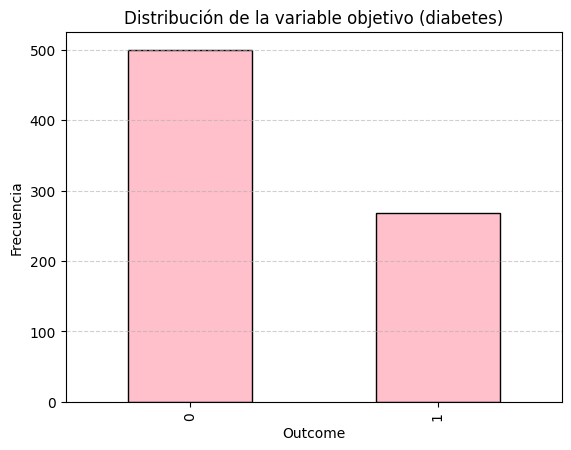

In [20]:
df_pd['Outcome'].value_counts().plot(kind='bar', color='pink', edgecolor='black')
plt.title("Distribución de la variable objetivo (diabetes)")
plt.xlabel("Outcome")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Matriz de correlacion

Calculamos la matriz de correlacion entre todas las variables del dataframe. Y es esencial para entender las relaciones entre variables
Los valores de correlación varían entre -1 y 1:
- 1: correlación positiva perfecta (ambas variables suben o bajan juntas).
- -1: correlación negativa perfecta (una variable sube mientras la otra baja).
- 0: no hay correlación lineal aparente.

En la matriz, los valores cercanos a 1 o -1 indican relaciones fuertes entre variables.Por ejemplo: Una alta correlación positiva entre Glucose y Outcome indicaría que niveles altos de glucosa están asociados con diabetes. Una correlación baja o cercana a 0 indica que la variable no está linealmente relacionada con la otra.

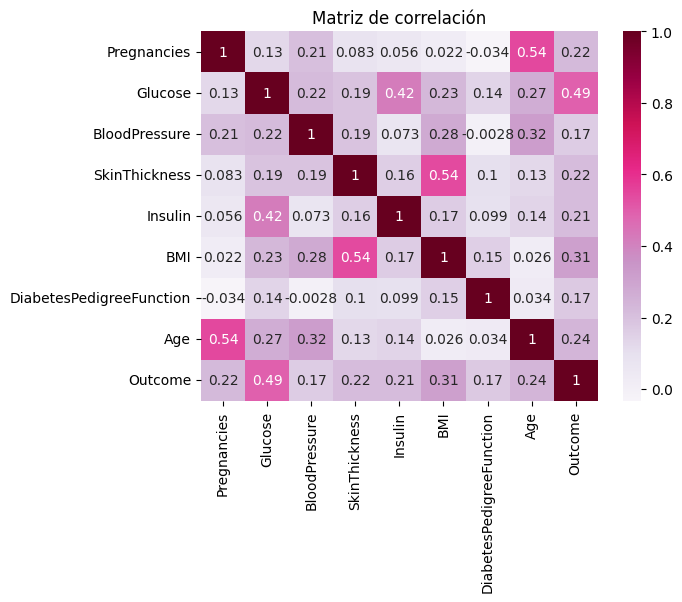

In [21]:
sns.heatmap(df_pd.corr(), annot=True, cmap='PuRd')
plt.title("Matriz de correlación")
plt.show()

## 4.Preprocesamiento tecnico (normlaizacion, codficacion, escalado, etc.)
Se preparan los datos para optimizar el desempeño de los modelos de ML

### Separar variables

Separamos las variables, variables independeintes (caracteristicas) y la variables dependiente (objetivo), es fundamental para entrenar el modelo ya que permite aprender la relacion entre las caracteriticas y el resultado

In [22]:
X = df_pd.drop("Outcome", axis=1).values
y = df_pd["Outcome"].values

### Escalado (normalizacion)

Este metodo transforma las variables para que tengan media = 0 y desviacion estandar = 1, estandariza los datos restando la media de cada caracteristica y dividiendola por si desviacion estandar. Asegura que todas las variables contribuyan equitativamente al aprendizaje del modelo.

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Division entrenamiento prueba

Separa los datos en entrenamiento y prueba, es esencial para evaluar si el modelo generaliza bien a datos nuevos
- X_train, y_train: datos para entrenar el modelo
- X_test, y_test: datos para evluar el rendimento del modelo con datos nuevos

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Tamaño del set de entrenamiento:", X_train.shape)
print("Tamaño del set de prueba:", X_test.shape)

Tamaño del set de entrenamiento: (614, 8)
Tamaño del set de prueba: (154, 8)


## 5.Entrenamiento del modelo ML

Se entrenaron 3 modelos ML para resolver el problema de prediccion del riesgo de diabetes. Y asi poder escoger el mas optimo para el problema 


### Modelo Random Forest



Primero entrenamos el modelo Random Forest.
Es un modelo de ensamble basado en árboles de decisión. Entrena múltiples árboles sobre subconjuntos aleatorios del conjunto de entrenamiento y promedia sus resultados para mejorar la precisión y reducir el sobreajuste. 

In [25]:
modeloRF = RandomForestClassifier(n_estimators=100, random_state=42)
modeloRF.fit(X_train, y_train)
y_predRF = modeloRF.predict(X_test)

### Modelo Regresion Logistica

Entrenamos el modelo Regresion Logistica
Es un modelo lineal de clasificación que estima la probabilidad de que un paciente tenga diabetes en función de una combinación lineal de las variables de entrada.

In [26]:
modeloLR = LogisticRegression()
modeloLR.fit(X_train, y_train)
y_predLR = modeloLR.predict(X_test)

### Modelo KNN

Y por ultimo entrenamos el modelo KNN. Este modelo clasifica una muestra en función de la clase mayoritaria entre sus "k" vecinos más cercanos en el espacio de características. No realiza un entrenamiento explícito, sino que guarda los datos y toma decisiones durante la predicción.

In [27]:
modeloKNN = KNeighborsClassifier(n_neighbors=5)
modeloKNN.fit(X_train, y_train)
y_predKNN = modeloKNN.predict(X_test)

## 6. Evaluacion del modelo
Una vez entrenados los modelos, vamos a ver el desempeño de cada uno y asi poder elegir al mas optimo para el problema

### Modelo Random Forest

Evaluamos el desempeño de este modelo y podemos ver que:
- El modelo acerto en aproximadamente el 77.2% de los casos 
- El 72.9% de los pacientes predichos como diabéticos realmente lo eran.
- El modelo identificó correctamente al 61.4% de los pacientes con diabetes reales.
- Buen equilibrio entre precisión y recall para la clase diabética.

El modelo tiene mejor desempeño en identificar pacientes sin diabetes, pero también logra detectar una parte importante de los casos positivos (diabéticos).

Evaluación del modelo:
Accuracy : 0.7727
Precision: 0.7292
Recall   : 0.6140
F1-score : 0.6667

Reporte completo:

              precision    recall  f1-score   support

 No Diabetes       0.79      0.87      0.83        97
    Diabetes       0.73      0.61      0.67        57

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.77      0.77       154



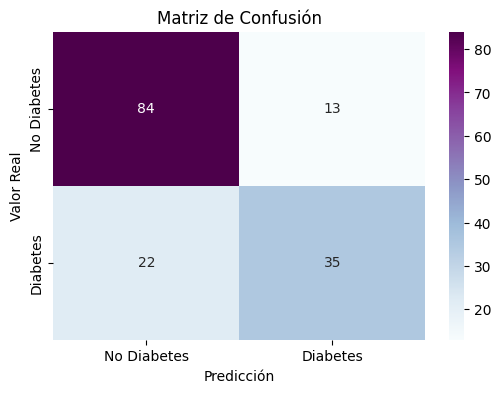

In [28]:
accuracyRF = accuracy_score(y_test, y_predRF)
precisionRF = precision_score(y_test, y_predRF)
recallRF = recall_score(y_test, y_predRF)
f1RF = f1_score(y_test, y_predRF)

print("Evaluación del modelo:")
print(f"Accuracy : {accuracyRF:.4f}")
print(f"Precision: {precisionRF:.4f}")
print(f"Recall   : {recallRF:.4f}")
print(f"F1-score : {f1RF:.4f}")
print("\nReporte completo:\n")
print(classification_report(y_test, y_predRF, target_names=["No Diabetes", "Diabetes"]))

# Matriz de confusión gráfica
cm = confusion_matrix(y_test, y_predRF)
labels = ["No Diabetes", "Diabetes"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

### Modelo Regresion Logistica

En este modelo podemos observar: 
- El modelo acertó en aproximadamente el 74.6% de los casos.
- El 72.5% de las predicciones positivas fueron correctas.
-  El modelo identificó correctamente al 50.8% de los pacientes con diabetes reales.
- Muestra un equilibrio moderado entre precisión y recall.

Evaluación del modelo:
Accuracy : 0.7468
Precision: 0.7250
Recall   : 0.5088
F1-score : 0.5979

Reporte completo:

              precision    recall  f1-score   support

 No Diabetes       0.75      0.89      0.82        97
    Diabetes       0.72      0.51      0.60        57

    accuracy                           0.75       154
   macro avg       0.74      0.70      0.71       154
weighted avg       0.74      0.75      0.73       154



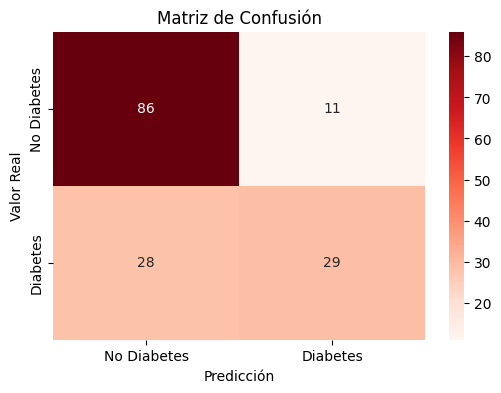

In [29]:
accuracyRL = accuracy_score(y_test, y_predLR)
precisionRL = precision_score(y_test, y_predLR)
recallRL = recall_score(y_test, y_predLR)
f1RL = f1_score(y_test, y_predLR)

print("Evaluación del modelo:")
print(f"Accuracy : {accuracyRL:.4f}")
print(f"Precision: {precisionRL:.4f}")
print(f"Recall   : {recallRL:.4f}")
print(f"F1-score : {f1RL:.4f}")
print("\nReporte completo:\n")
print(classification_report(y_test, y_predLR, target_names=["No Diabetes", "Diabetes"]))

# Matriz de confusión gráfica
cm = confusion_matrix(y_test, y_predLR)
labels = ["No Diabetes", "Diabetes"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

### Modelo KNN

Y por ultimo en este modelo:
- El modelo acertó en el 75% de las predicciones
- El 70% de los pacientes predichos como diabéticos realmente lo eran
- El modelo identificó correctamente solo al 57% de los pacientes con diabetes reales
- El equilibrio entre precisión y recall es moderadamente bajo en comparación con los otros modelos


Evaluación del modelo:
Accuracy : 0.7532
Precision: 0.7021
Recall   : 0.5789
F1-score : 0.6346

Reporte completo:

              precision    recall  f1-score   support

 No Diabetes       0.78      0.86      0.81        97
    Diabetes       0.70      0.58      0.63        57

    accuracy                           0.75       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



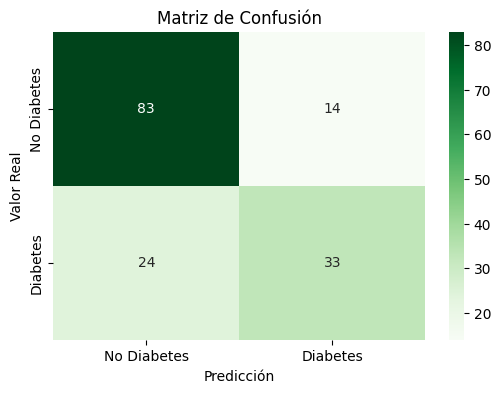

In [30]:
accuracyKNN = accuracy_score(y_test, y_predKNN)
precisionKNN = precision_score(y_test, y_predKNN)
recallKNN = recall_score(y_test, y_predKNN)
f1KNN = f1_score(y_test, y_predKNN)

print("Evaluación del modelo:")
print(f"Accuracy : {accuracyKNN:.4f}")
print(f"Precision: {precisionKNN:.4f}")
print(f"Recall   : {recallKNN:.4f}")
print(f"F1-score : {f1KNN:.4f}")
print("\nReporte completo:\n")
print(classification_report(y_test, y_predKNN, target_names=["No Diabetes", "Diabetes"]))

# Matriz de confusión gráfica
cm = confusion_matrix(y_test, y_predKNN)
labels = ["No Diabetes", "Diabetes"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

### Comparacion accuracy entre modelos

Este grafico de barras resume y compara el desempeño de los tres modelos en terminos de su precision global (accuracy):
Random Forest obtuvo el mayor valor de accuracy lo que indica que fue el modelo que mas predicciones correctas logro, KNN fue el accuracy mas bajo presentando un

C:\Users\camil\AppData\Local\Temp\ipykernel_23848\2521167306.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resultados_accuracy.keys()), y=list(resultados_accuracy.values()), palette="mako")


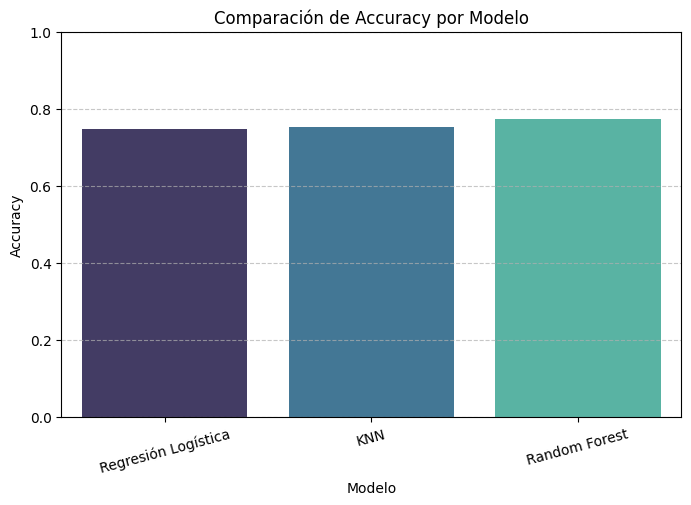

In [31]:
resultados_accuracy = {
    "Regresión Logística": accuracyRL,
    "KNN": accuracyKNN,
    "Random Forest": accuracyRF
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(resultados_accuracy.keys()), y=list(resultados_accuracy.values()), palette="mako")

plt.title("Comparación de Accuracy por Modelo")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlabel("Modelo")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Comparacion precision por modelo

Comparamos la precision de cada modelo para detectar correctamente los casos positivos: Nuevamente Random Forest obtuvo la mayor precision lo que indica que cuando predice diabetes es mas probable que esa prediccion sea correcta, y KNN tuvo la mas baja, indicando un mayor porcentaje de falsos positivos

C:\Users\camil\AppData\Local\Temp\ipykernel_23848\3238174704.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resultados_precision.keys()), y=list(resultados_precision.values()), palette="icefire")


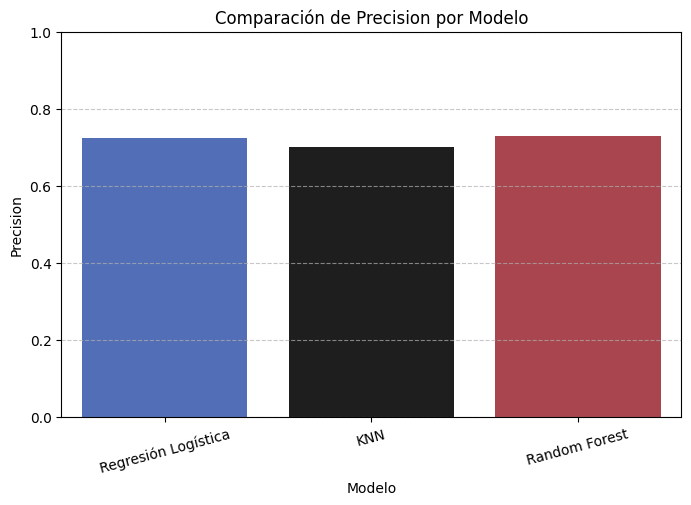

In [32]:
resultados_precision = {
    "Regresión Logística": precisionRL,
    "KNN": precisionKNN,
    "Random Forest": precisionRF
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(resultados_precision.keys()), y=list(resultados_precision.values()), palette="icefire")

plt.title("Comparación de Precision por Modelo")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.xlabel("Modelo")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Comparacion de Recall por modelo

Hacemos una comparacion de recall por modelo para detectar correctamente a los pasientes con diabetes y nos mostro: Random Forest tiene el recall mas alto, indicando que detecta una mayor proporcion de casos psotivos reales, regresion logistica presenta el mas bajo lo que significa que tiene falsos negativos.

El recall es fundamental en problemas médicos, ya que un bajo recall implica más falsos negativos, lo que puede significar que pacientes con diabetes no son identificados y, por lo tanto, no reciben el tratamiento adecuado a tiempo.

C:\Users\camil\AppData\Local\Temp\ipykernel_23848\2189784741.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resultados_recall.keys()), y=list(resultados_recall.values()), palette="rocket")


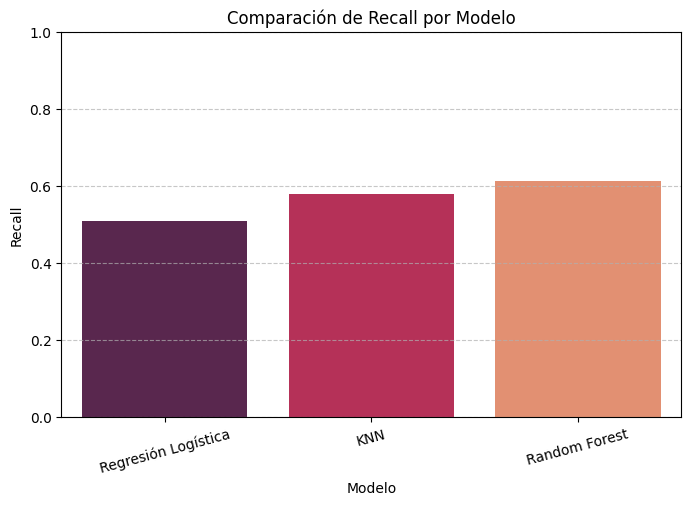

In [33]:
resultados_recall = {
    "Regresión Logística": recallRL,
    "KNN": recallKNN,
    "Random Forest": recallRF
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(resultados_recall.keys()), y=list(resultados_recall.values()), palette="rocket")

plt.title("Comparación de Recall por Modelo")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.xlabel("Modelo")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Comparacion de f1-score por modelo

En este grafico comparamos el f1-score que combina la precision y el recall en un solo valor balanceando los falsos positivos y falsos negativos. Nos mostro: Random Forest tuvo el mas alto mostrando un buen balance, regresion logistica tuvo el mas bajo 

C:\Users\camil\AppData\Local\Temp\ipykernel_23848\1407258253.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(resultados_f1.keys()), y=list(resultados_f1.values()), palette="flare")


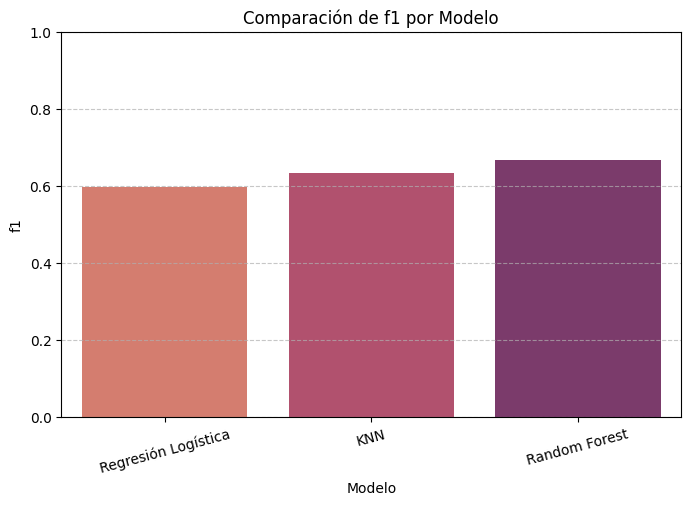

In [34]:
resultados_f1 = {
    "Regresión Logística": f1RL,
    "KNN": f1KNN,
    "Random Forest": f1RF
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(resultados_f1.keys()), y=list(resultados_f1.values()), palette="flare")

plt.title("Comparación de f1 por Modelo")
plt.ylabel("f1")
plt.ylim(0, 1)
plt.xlabel("Modelo")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Despues de este analisis, se puede concluir que el mejor modelo a utilizar es el *Random Forest* ya que tuvo el mejor desempeño global, la mayor precision, el mejor recall  y el F1-score mas alto. Esto indica que es el modelo más efectivo para predecir correctamente tanto pacientes diabéticos como no diabéticos.

En cambio los otros modelos: 
- Regresión Logística: Aunque es un modelo simple y rápido, su menor recall indica que pierde más casos positivos reales, lo que podría ser riesgoso para diagnóstico médico.
- KNN: Presento al igual que la regresion logistica niveles bajos en las categorias

## 7.Visualizacion de resultados y metricas

En esta sección se presentan las principales visualizaciones que resumen el desempeño del modelo Random Forest entrenado para la predicción de riesgo de diabetes

### Matriz de confusion

Se observa el número de aciertos y errores por clase, identificando verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos. Esto es clave para entender dónde falla el modelo.
Cada celda contiene el número de casos que corresponden a una combinación específica de valores reales vs. predichos.
La diagonal principal muestra las predicciones correctas:
- "No Diabetes" correctamente clasificados en la celda superior izquierda.
- "Diabetes" correctamente clasificados en la celda inferior derecha.

Las celdas fuera de la diagonal indican errores de clasificación:

- Falsos positivos (pacientes sin diabetes predichos como diabéticos).
- Falsos negativos (pacientes con diabetes no detectados).

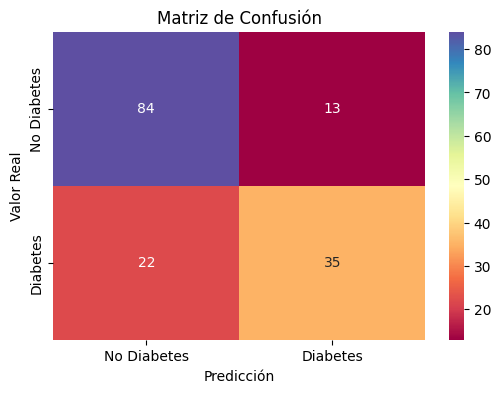

In [35]:
cm = confusion_matrix(y_test, y_predRF)
labels = ["No Diabetes", "Diabetes"]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

## Metricas

Barras que resumen visualmente el rendimiento general del modelo, facilitando la interpretación rápida de sus fortalezas y limitaciones.

C:\Users\camil\AppData\Local\Temp\ipykernel_23848\918716708.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metricas.keys()), y=list(metricas.values()), palette="viridis")


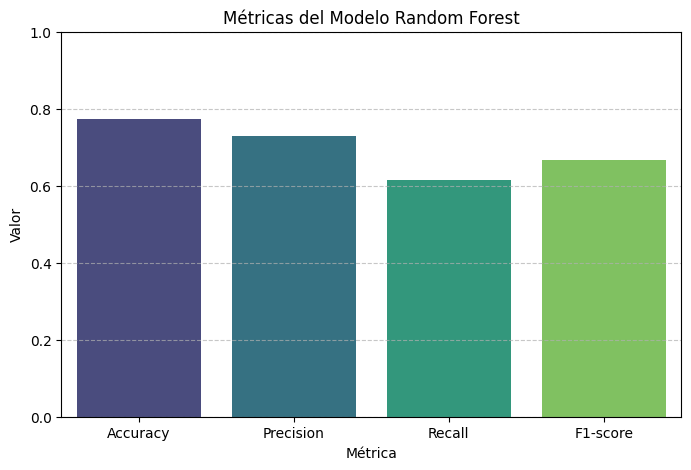

In [36]:
metricas = {
    "Accuracy": accuracyRF,
    "Precision": precisionRF,
    "Recall": recallRF,
    "F1-score": f1RF
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(metricas.keys()), y=list(metricas.values()), palette="viridis")

plt.title("Métricas del Modelo Random Forest")
plt.ylim(0, 1)
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Curva Roc

Esta gráfica te ayuda a visualizar la capacidad del modelo para distinguir entre pacientes diabéticos y no diabéticos a distintos umbrales, y el AUC resume esa capacidad en un solo número entre 0 y 1 (más cercano a 1 es mejor). 

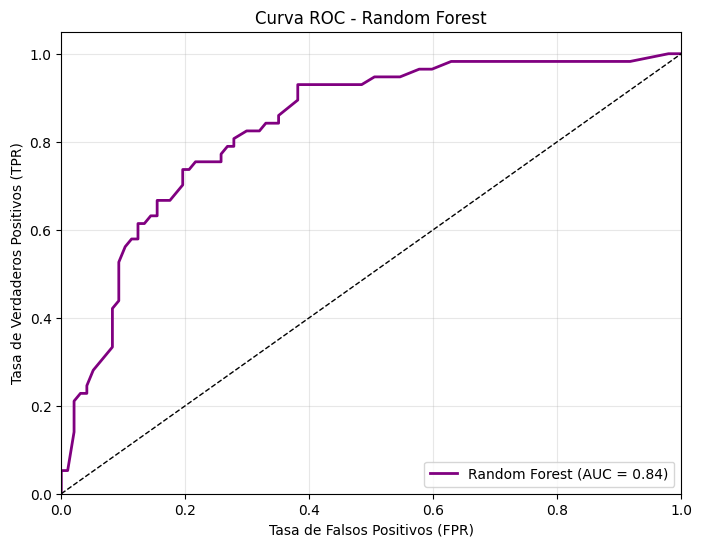

In [37]:
y_probRF = modeloRF.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probRF)
roc_auc = roc_auc_score(y_test, y_probRF)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})", color='purple', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()